### 1. Imports

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import gym
import numpy as np
from stable_baselines3 import PPO, A2C
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

In [2]:
# Import classes
from rl_environment import Environment

### 2. Environment creation

#### Parameters for Simulation

In [3]:
number_of_regional_warehouses = 3
max_inventory_amount_regional_warehouses = 30
max_inventory_amount_central_warehouse = 60
customer_demand_per_step = [2,3,1]  # List needs one entry per regional warehouse 
simulation_length = 40
lead_time = 2
shipment_amount = [10]  # Regarding regional warehouses
with_manufacturer = True
cw_shipment_amount = 15  # Regarding central warehosue
manufacturer_prod_capacity_per_step = 10
shipment_var_cost_per_unit = 0.002
shipment_fixed_cost = .025  # Reward penalty
inventory_holding_cost_multiplier = 1 # Standard = 1; Can be lowered; Not higher that 1
cw_inventory_holding_cost_multiplier = .35
demand_fluctuation = 0
lead_time_fluctuation = 0

#### Parameters for Agent Training

In [4]:
algorithm = "PPO"  # "PPO" or "A2C"
training_steps = 150000

print("-> Equals to " + str(int(training_steps/simulation_length)) + " simulation training rounds")

-> Equals to 3750 simulation training rounds


#### Creating Environment

In [5]:
env = Environment(number_of_regional_wh = number_of_regional_warehouses, 
                  rw_inventory_limit = max_inventory_amount_regional_warehouses, 
                  cw_inventory_limit = max_inventory_amount_central_warehouse,
                  demand = customer_demand_per_step,
                  sim_length = simulation_length,
                  lead_time = lead_time,
                  shipment_amount = shipment_amount,
                  manufacturer = with_manufacturer,
                  cw_shipment_amount = cw_shipment_amount,
                  mf_prod_capacity = manufacturer_prod_capacity_per_step,
                  shipment_var_cost_per_unit = shipment_var_cost_per_unit,
                  shipment_fixed_cost = shipment_fixed_cost,
                  inventory_holding_cost_multiplier = inventory_holding_cost_multiplier,
                  cw_inventory_holding_cost_multiplier = cw_inventory_holding_cost_multiplier,
                  demand_fluctuation = demand_fluctuation,
                  lead_time_fluctuation = lead_time_fluctuation
                 )

env.print_environment_information()

Simulation created with the following parameters:
________________________________________________________________________________
Simulation | Round 1
-------------------
-> Active shipments:
No active shipments

-> Warehouses:
central_warehouse ; Inventory: 20
regional_warehouse_1 ; ID: 1 ; Inventory: 10 ; Demand: 2 ; Lost sales: 0
regional_warehouse_2 ; ID: 2 ; Inventory: 10 ; Demand: 3 ; Lost sales: 0
regional_warehouse_3 ; ID: 3 ; Inventory: 10 ; Demand: 1 ; Lost sales: 0

-> Production plant:
manufacturer ; Production per step: 10 ; Inventory: 100
________________________________________________________________________________
Environment Information
-----------------------
-> Gym spaces:
Observation space: Dict(cw_inventory:Discrete(61), rw_inventories:MultiDiscrete([31 31 31]), shipments:MultiDiscrete([2 2 2]))
Action space: MultiDiscrete([2 2 2 2])
Starting state: {'rw_inventories': array([10, 10, 10]), 'shipments': array([0, 0, 0]), 'cw_inventory': 20}

-> Reward penalty per 

### 3. RL model training

###### Model Selection
PPO (Proximal Policy Optimization)
https://openai.com/blog/openai-baselines-ppo/

A2C
https://openai.com/blog/baselines-acktr-a2c/

In [6]:
if algorithm.upper() == "PPO":
    trained_model = PPO("MultiInputPolicy", env, verbose=1)
elif algorithm.upper() == "A2C":
    trained_model = A2C("MultiInputPolicy", env, verbose=1)
else:
    print("Model not found")
    exit()
trained_model.learn(total_timesteps=training_steps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40       |
|    ep_rew_mean     | 0.526    |
| time/              |          |
|    fps             | 641      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 0.632       |
| time/                   |             |
|    fps                  | 510         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013019826 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 3.1         |
| time/                   |             |
|    fps                  | 414         |
|    iterations           | 11          |
|    time_elapsed         | 54          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.013742629 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.49       |
|    explained_variance   | 0.456       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.131       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0314     |
|    value_loss           | 0.269       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 40      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 4.11        |
| time/                   |             |
|    fps                  | 389         |
|    iterations           | 21          |
|    time_elapsed         | 110         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.017837666 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.403       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.184       |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0312     |
|    value_loss           | 0.48        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 4.99        |
| time/                   |             |
|    fps                  | 365         |
|    iterations           | 31          |
|    time_elapsed         | 173         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.014404662 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.568       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.205       |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0267     |
|    value_loss           | 0.591       |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 40        

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 6.24        |
| time/                   |             |
|    fps                  | 355         |
|    iterations           | 41          |
|    time_elapsed         | 235         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.012668678 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.21       |
|    explained_variance   | 0.62        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.304       |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.019      |
|    value_loss           | 0.812       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 40      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 7.19        |
| time/                   |             |
|    fps                  | 354         |
|    iterations           | 51          |
|    time_elapsed         | 294         |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.012798624 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.89       |
|    explained_variance   | 0.531       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.696       |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 1.27        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 7.28        |
| time/                   |             |
|    fps                  | 349         |
|    iterations           | 61          |
|    time_elapsed         | 357         |
|    total_timesteps      | 124928      |
| train/                  |             |
|    approx_kl            | 0.009872804 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.786      |
|    explained_variance   | 0.382       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.03        |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.00888    |
|    value_loss           | 1.58        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 7.33        |
| time/                   |             |
|    fps                  | 345         |
|    iterations           | 71          |
|    time_elapsed         | 421         |
|    total_timesteps      | 145408      |
| train/                  |             |
|    approx_kl            | 0.010395061 |
|    clip_fraction        | 0.0732      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.63       |
|    explained_variance   | 0.279       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.83        |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.00561    |
|    value_loss           | 1.82        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40    

###### Learning Curve

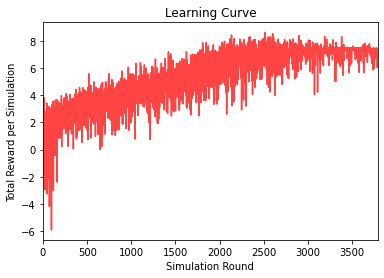

In [7]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(env.total_reward, color="#FF4444")
plt.title("Learning Curve")
plt.xlim(0, len(env.total_reward))
plt.ylabel("Total Reward per Simulation")
plt.xlabel("Simulation Round")
plt.show()

### 4. Run simulation

In [8]:
# Convert actions for graphs
def convert_to_marker_pos(action):
    return_list = []
    i = 0
    for entry in action:
        if entry != 0:
            return_list.append(i)
        i += 1
    return return_list


# Graph data
cw_inventory_level, cw_actions = [], []
inventory_levels, actions = {}, {}
manufacturer_inventory = []

for rw_id in env.simulation.get_regional_warehouses():
    inventory_levels[rw_id] = [0]
    actions[rw_id] = [0]

In [9]:
# Reset environment for simulation
state = env.reset()
done = False

# Run simulation with model
while not done:
    action, _states = trained_model.predict(state)
    state, reward, done, info = env.step(action)
    
    # For Graph
    i = 1
    for inv in info["RW Invs:"]:
        inventory_levels[i].append(inv)
        i += 1

    i = 1
    for act in info["Action:"][0:len(env.simulation.get_regional_warehouses())]:
        actions[i].append(act)
        i += 1
    
    try:
        cw_inventory_level.append(info["CW Inv:"])
        cw_actions.append(info["Action:"][-1])
        manufacturer_inventory.append(info["Manufacturer:"])
    except:
        pass
    
    # print(env.simulation.print_state())
    for i in info:
        print(i, info[i], end=" | ")
    print()
    
print("\n", env.evaluation_parameters())

Round: 1 | RW Invs: [8, 7, 9] | Shipments [0, 1, 0] | Action: [0, 1, 0, 0] | Reward: 0.08 | CW Inv: 10 | Manufacturer: 90 | 
Round: 2 | RW Invs: [6, 4, 8] | Shipments [0, 1, 0] | Action: [0, 1, 0, 1] | Reward: 0.19 | CW Inv: 0 | Manufacturer: 85 | 
Round: 3 | RW Invs: [4, 11, 7] | Shipments [0, 1, 0] | Action: [0, 0, 0, 1] | Reward: 0.19 | CW Inv: 0 | Manufacturer: 80 | 
Round: 4 | RW Invs: [2, 18, 6] | Shipments [1, 0, 0] | Action: [1, 0, 0, 0] | Reward: 0.14 | CW Inv: 5 | Manufacturer: 90 | 
Round: 5 | RW Invs: [0, 15, 5] | Shipments [1, 1, 0] | Action: [1, 1, 0, 0] | Reward: 0.37 | CW Inv: 0 | Manufacturer: 100 | 
Round: 6 | RW Invs: [8, 12, 4] | Shipments [1, 1, 0] | Action: [1, 1, 1, 1] | Reward: 0.15 | CW Inv: 0 | Manufacturer: 85 | 
Round: 7 | RW Invs: [16, 19, 3] | Shipments [0, 0, 0] | Action: [0, 1, 1, 1] | Reward: 0.15 | CW Inv: 0 | Manufacturer: 80 | 
Round: 8 | RW Invs: [14, 16, 2] | Shipments [0, 1, 0] | Action: [0, 1, 1, 0] | Reward: 0.11 | CW Inv: 5 | Manufacturer: 90 |

###### Inventory level graphs

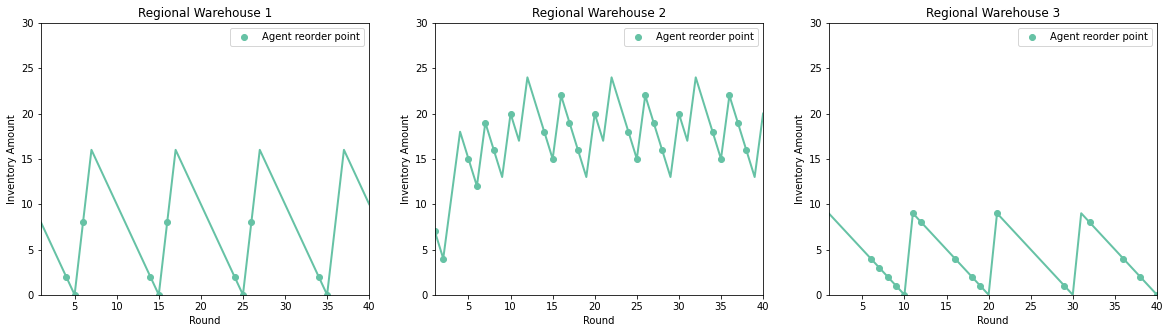

In [10]:
# Plot inventories of regional warehouses

reorder_marker = mlines.Line2D([],[], color='#66C2A5', marker='o', linestyle='None', label="Agent reorder point")
plt.rcParams["figure.figsize"] = (20, 5)

for rw_id in inventory_levels:
    plt.subplot(1, number_of_regional_warehouses, rw_id)
    plt.plot(inventory_levels[rw_id], "-bo", markevery=convert_to_marker_pos(actions[rw_id]), color="#66C2A5", linewidth=2)
    plt.legend(handles=[reorder_marker])
    plt.title("Regional Warehouse " + str(rw_id))
    plt.ylim(0, max_inventory_amount_regional_warehouses)
    plt.xlim(1, simulation_length)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    
    if False:
        print("RW", rw_id, "data:")
        print("Inventory:", inventory_levels[rw_id])
        print("Actions:", actions[rw_id])
        print("_"*100)

plt.show()

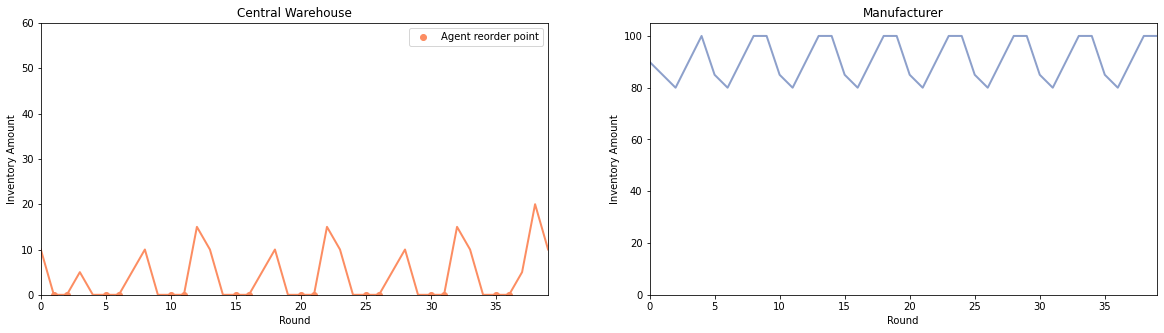

In [11]:
# Plot central warehouse inventory (Only display if simulated by adding a manufacturer)
if len(cw_inventory_level) != 0:
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.subplot(1, 2, 1)
    reorder_marker = mlines.Line2D([],[], color='#FC8D62', marker='o', linestyle='None', label="Agent reorder point")
    plt.plot(cw_inventory_level, "-bo", color="#FC8D62", markevery=convert_to_marker_pos(cw_actions), linewidth=2)
    plt.legend(handles=[reorder_marker])
    plt.title("Central Warehouse")
    plt.ylim(0, max_inventory_amount_central_warehouse)
    plt.xlim(0, simulation_length-1)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    
    plt.subplot(1, 2, 2)
    plt.plot(manufacturer_inventory, color="#8DA0CB", linewidth=2)
    plt.title("Manufacturer")
    plt.ylim(0, env.simulation.get_manufacturer().get_inventory_limit()+5)
    plt.xlim(0, simulation_length-1)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    plt.show()